In [92]:
import pandas as pd
import datetime
import requests
import json
import sys, os
import itertools
import time
import numpy as np
from os import path
from pathlib import Path
from binance.spot import Spot
from twelvedata import TDClient
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
import itertools
import xgboost as xgb
import seaborn as sns
from typing import Union, Dict, List
import talib
import ta
import shap
sys.path.insert(0, os.path.join(os.getcwd(), ".."))
import fin_utilities 
import sklearn
import scikitplot as skplt
import matplotlib.pyplot as plt
cfg = fin_utilities.__cfg_reading("pred")
import my_functions

import matplotlib as mpl
# Set the default color cycle
mpl.rcParams.update(mpl.rcParamsDefault)


#td = TDClient(apikey=cfg['TWELVEDATA']['API'])  

PROJECT_DIR = eval(cfg['PROJECT_PATH'])
DATA_PATH   = PROJECT_DIR / cfg['DATA_FOLDER']
SOURCE      = cfg['API_DATA_SOURCE']
URL         = cfg[SOURCE]['API_URL_HIST_DATA']
COLUMNS     = cfg[SOURCE]['COLUMN_NAMES']
PARAMS      = cfg[SOURCE]['REQ_PARAMS']
PAIR        = cfg['SYMBOL'] + cfg['STABLECOIN']
MAX_LENGTH  = cfg['MAX_TRADE_DURATION']
XGB_PARAM   = cfg['xgb']


In [93]:
if SOURCE == 'BINANCE':
    PARAMS.update({'startTime': my_functions.datetime_to_ts(PARAMS['startTime'])})
    PARAMS.update({'endTime': my_functions.datetime_to_ts(PARAMS['endTime'])})

PARAMS  

limit=1000

In [94]:
def plot_correlogram(x, lags=None, title=None):
    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    
    x.plot(ax=axes[0][0], title='Residuals')
    
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    
    probplot(x, plot=axes[0][1])
    
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    
    axes[1][0].set_xlabel('Lag')
    
    axes[1][1].set_xlabel('Lag')
    
    fig.suptitle(title, fontsize=14)
    
    sns.despine()
    
    fig.tight_layout()
    
    fig.subplots_adjust(top=.9)
    plt.show()
    
    return

In [95]:
compare_other_symbols = True
# new_connection
client = Spot()

df = my_functions.load_data(client, PAIR, DATA_PATH, PARAMS, COLUMNS)


if compare_other_symbols:

    pairs_available = my_functions.get_all_pairs_available(client)

    # prendo le top coin e rimuovo il simbolo in cfg se c'è
    symbols, actualized_mc = my_functions.get_top_symbols_by_marketcap(40, cfg['STABLECOIN'])
    symbols = [el for el in symbols if el not in PAIR]

    for s in symbols:

        if s in pairs_available:
            
            df = pd.concat([df,my_functions.load_data(client, s, DATA_PATH, PARAMS, COLUMNS)], ignore_index=True)


Loading BTCUSDT_1d.csv.
Loading ETHUSDT_1d.csv.
Loading BNBUSDT_1d.csv.
Loading XRPUSDT_1d.csv.
Loading ADAUSDT_1d.csv.
Loading MATICUSDT_1d.csv.
Loading DOGEUSDT_1d.csv.
Loading SOLUSDT_1d.csv.
Loading DOTUSDT_1d.csv.
Loading SHIBUSDT_1d.csv.
Loading LTCUSDT_1d.csv.
Loading TRXUSDT_1d.csv.
Loading AVAXUSDT_1d.csv.
Loading DAIUSDT_1d.csv.
Loading UNIUSDT_1d.csv.
Loading ATOMUSDT_1d.csv.
Loading LINKUSDT_1d.csv.
Loading ETCUSDT_1d.csv.
Loading XMRUSDT_1d.csv.
Loading BCHUSDT_1d.csv.
Loading XLMUSDT_1d.csv.
Loading LDOUSDT_1d.csv.
Loading APTUSDT_1d.csv.
Loading HBARUSDT_1d.csv.
Loading NEARUSDT_1d.csv.
Loading QNTUSDT_1d.csv.
Loading FILUSDT_1d.csv.
Loading APEUSDT_1d.csv.
Loading ALGOUSDT_1d.csv.
Loading VETUSDT_1d.csv.
Loading ICPUSDT_1d.csv.


In [96]:
df.drop(columns=['OpenTimestamp', 'Ignore.'], inplace=True, errors='ignore')
df['Mkt_Cap'] = df['Close']*df['Volume']

df_mkt_cap = df.groupby(['CloseTimestamp'])['Mkt_Cap'].sum().reset_index()
df_mkt_cap.head(5)

,CloseTimestamp,Mkt_Cap
0,2017-08-18 01:59:59.999,5.530558e+06
1,2017-08-19 01:59:59.999,7.733330e+06
2,2017-08-20 01:59:59.999,2.202965e+06
3,2017-08-21 01:59:59.999,2.659419e+06
4,2017-08-22 01:59:59.999,4.465435e+06


In [97]:
df

,Open,High,Low,Close,Volume,CloseTimestamp,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Symbol,Mkt_Cap
0,4261.480,4485.390,4200.740,4285.080,7.951504e+02,2017-08-18 01:59:59.999,3.454770e+06,3427,6.162485e+02,2.678216e+06,BTCUSDT,3.407283e+06
1,4285.080,4371.520,3938.770,4108.370,1.199888e+03,2017-08-19 01:59:59.999,5.086958e+06,5233,9.728687e+02,4.129123e+06,BTCUSDT,4.929585e+06
2,4108.370,4184.690,3850.000,4139.980,3.813098e+02,2017-08-20 01:59:59.999,1.549484e+06,2153,2.743360e+02,1.118002e+06,BTCUSDT,1.578615e+06
3,4120.980,4211.080,4032.620,4086.290,4.670830e+02,2017-08-21 01:59:59.999,1.930364e+06,2321,3.767959e+02,1.557401e+06,BTCUSDT,1.908637e+06
4,4069.130,4119.620,3911.790,4016.000,6.917431e+02,2017-08-22 01:59:59.999,2.797232e+06,3972,5.573561e+02,2.255663e+06,BTCUSDT,2.778040e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
35770,3.817,3.945,3.765,3.902,1.266354e+06,2023-01-07 00:59:59.999,4.854114e+06,23001,6.511878e+05,2.496709e+06,ICPUSDT,4.941314e+06
35771,3.902,4.041,3.890,4.014,1.020408e+06,2023-01-08 00:59:59.999,4.050694e+06,19415,5.107739e+05,2.028402e+06,ICPUSDT,4.095919e+06
35772,4.014,4.133,3.938,4.115,1.069798e+06,2023-01-09 00:59:59.999,4.330454e+06,22903,5.412401e+05,2.191238e+06,ICPUSDT,4.402219e+06
35773,4.114,4.375,4.091,4.246,2.245088e+06,2023-01-10 00:59:59.999,9.555204e+06,46159,1.133205e+06,4.822755e+06,ICPUSDT,9.532644e+06


In [99]:
df_btc = pd.merge(df[df['Symbol']==PAIR], df_mkt_cap, on='CloseTimestamp', suffixes=[None, '_tot'])
df_btc.drop(columns=['Symbol', 'Quote asset volume','Taker buy base asset volume','Taker buy quote asset volume', 'Mkt_Cap','Mkt_Cap_tot'], errors='ignore', inplace=True)
df_btc['CloseTimestamp'] = df_btc['CloseTimestamp'].dt.date
df_btc.head(5)

,Open,High,Low,Close,Volume,CloseTimestamp,Number of trades
0,4261.48,4485.39,4200.74,4285.08,795.150377,2017-08-18,3427
1,4285.08,4371.52,3938.77,4108.37,1199.888264,2017-08-19,5233
2,4108.37,4184.69,3850.00,4139.98,381.309763,2017-08-20,2153
3,4120.98,4211.08,4032.62,4086.29,467.083022,2017-08-21,2321
4,4069.13,4119.62,3911.79,4016.00,691.743060,2017-08-22,3972


In [73]:
df_btc['AVG_Candle_Price'] = (df_btc['Open']+df_btc['High']+df_btc['Low']+df_btc['Close'])/4
df_btc['Detrended_Open'] = df_btc['Open'] - df_btc['EMA_VOL_30d']
df_btc['Open_minus_prev'] = df_btc['Open'] - df_btc['Open'].diff().dropna()
df_btc['AVG_Candle_mins_prev'] = df_btc['AVG_Candle_Price'] - df_btc['AVG_Candle_Price'].diff().fillna(0)
df_btc['AVG_Candle_Price_ema'] = my_functions.rolling_kpi(df_btc,'AVG_Candle_Price',30, 'ema', False)
df_btc['AVG_Candle_Price_detrended'] = np.log((df_btc['AVG_Candle_Price'] - df_btc['AVG_Candle_Price_ema'])**2)
df_btc['AVG_Candle_Price_detrended'] = df_btc['AVG_Candle_Price_detrended'].replace([np.inf, -np.inf],1)

divide by zero encountered in log


In [74]:
tmp

,Open,High,Low,Close,Volume,CloseTimestamp,Number of trades,EMA_VOL_30d,Detrended_Open,Open_minus_prev,AVG_Candle_Price,AVG_Candle_mins_prev,AVG_Candle_Price_ema,AVG_Candle_Price_detrended
0,4261.48,4485.39,4200.74,4285.08,795.150377,2017-08-18,3427,4261.480000,0.000000,NaN,4308.1725,4308.1725,4308.172500,1.000000
1,4285.08,4371.52,3938.77,4108.37,1199.888264,2017-08-19,5233,4273.673333,11.406667,4261.48,4175.9350,4308.1725,4239.849792,8.315102
2,4108.37,4184.69,3850.00,4139.98,381.309763,2017-08-20,2153,4214.859374,-106.489374,4285.08,4070.7600,4175.9350,4179.688633,9.381386
3,4120.98,4211.08,4032.62,4086.29,467.083022,2017-08-21,2321,4188.992186,-68.012186,4108.37,4112.7425,4070.7600,4161.242534,7.763129
4,4069.13,4119.62,3911.79,4016.00,691.743060,2017-08-22,3972,4161.720636,-92.590636,4120.98,4029.1350,4112.7425,4131.184871,9.250923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,16831.85,17041.00,16679.00,16950.65,207401.284150,2023-01-07,5388661,16857.955020,-26.105020,16850.36,16875.6250,16828.7575,16858.156877,5.720755
1969,16950.31,16981.91,16908.00,16943.57,104526.568800,2023-01-08,3227161,16863.913406,86.396594,16831.85,16945.9475,16875.6250,16863.820788,8.816527
1970,16943.83,17176.99,16911.00,17127.83,135155.896950,2023-01-09,4036092,16869.069315,74.760685,16950.31,17039.9125,16945.9475,16875.181544,10.208627
1971,17127.83,17398.80,17104.66,17178.26,266211.527230,2023-01-10,6327667,16885.763553,242.066447,16943.83,17202.3875,17039.9125,16896.291606,11.447797


The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


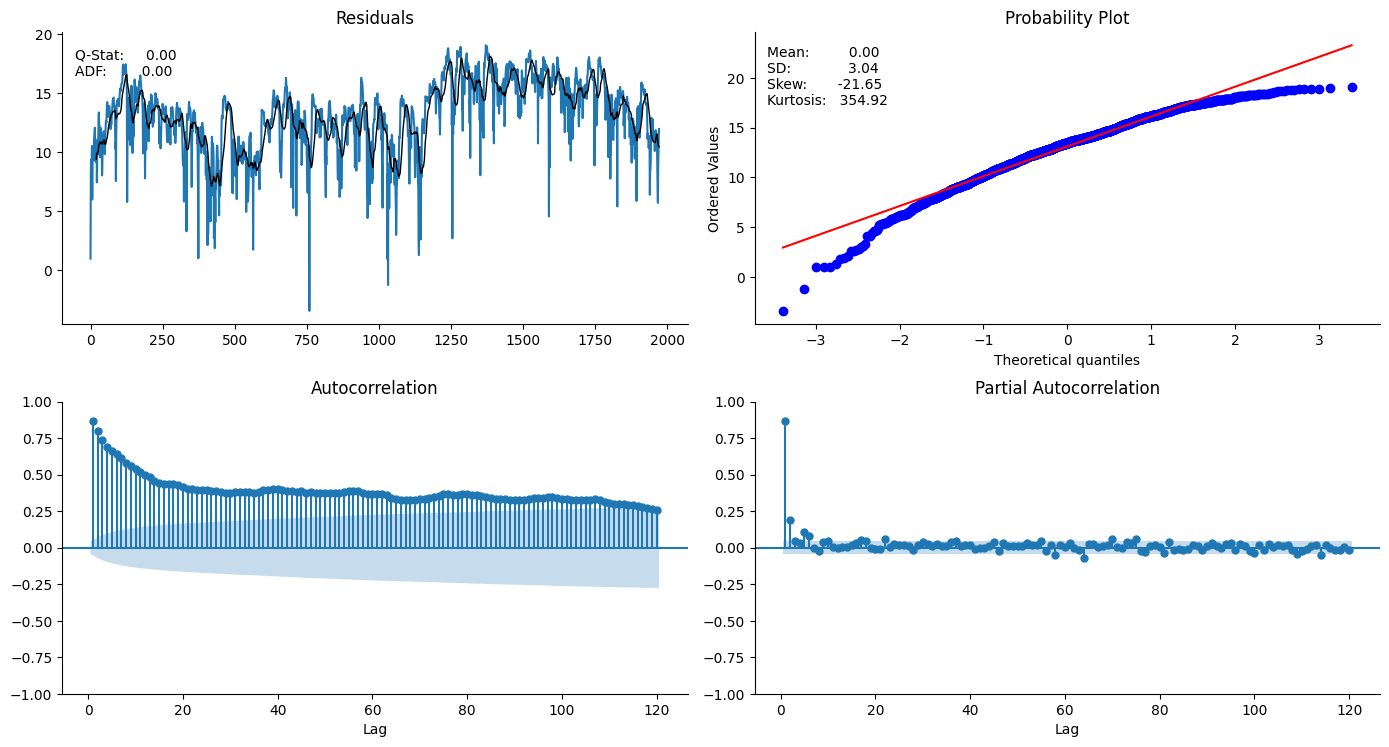

In [76]:
plot_correlogram(x=df_btc['AVG_Candle_Price_detrended'],
                 lags=120,
                 title=None)

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


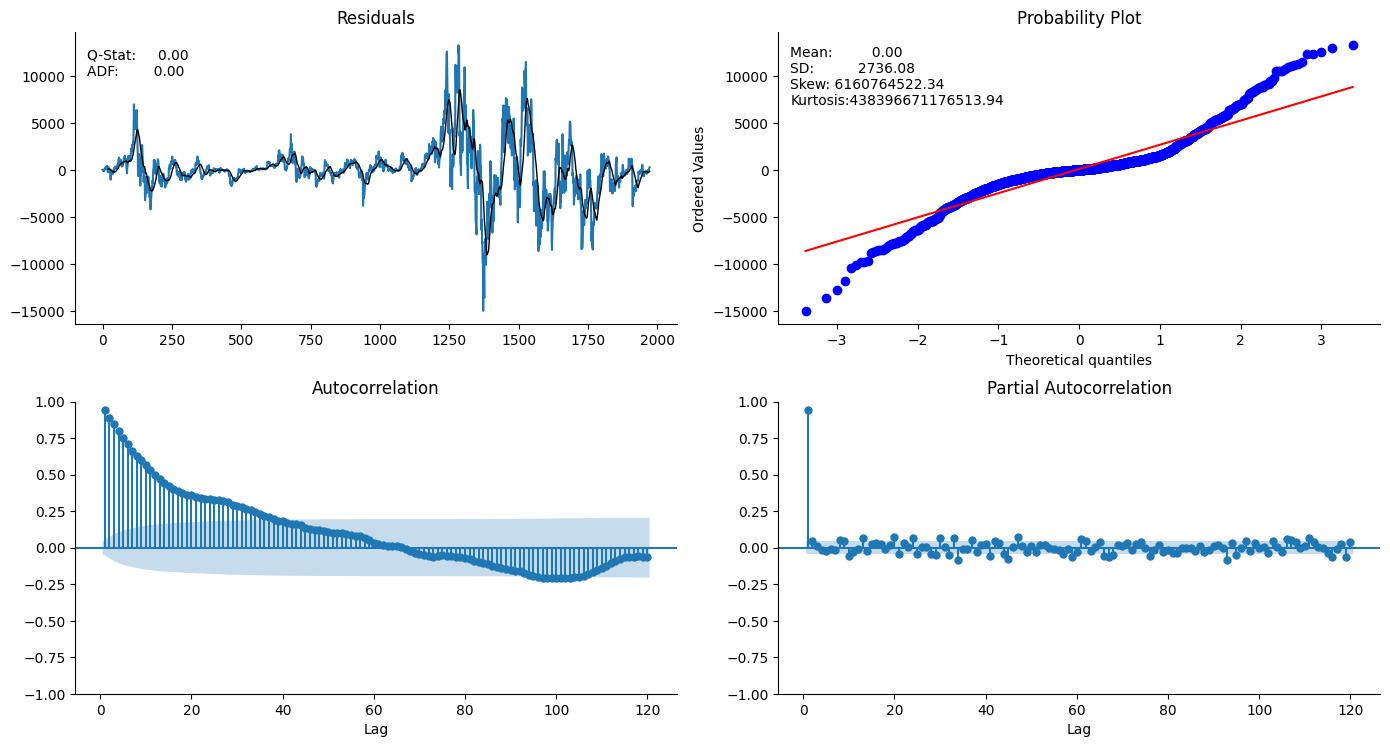

In [24]:
plot_correlogram(x=df_btc['Detrended_Open'],
                 lags=120,
                 title=None)

In [77]:
df_btc = my_functions.labelize_output_according_criterion2(df_btc, ['Open','High','Low','Close'], max_trade_length=MAX_LENGTH)
df_btc['signal'] = (df_btc['min_above'].lt(df_btc['min_below'])) & (df_btc['min_above'] <= MAX_LENGTH)
df_btc['signal']=df_btc['signal'].astype(int)
df_btc.tail(10)

,Open,High,Low,Close,Volume,CloseTimestamp,Number of trades,EMA_VOL_30d,Detrended_Open,Open_minus_prev,AVG_Candle_Price,AVG_Candle_mins_prev,AVG_Candle_Price_ema,AVG_Candle_Price_detrended,TP,SL,min_above,min_below,signal
1963,16541.77,16628.00,16499.01,16616.75,96925.41374,2023-01-02,3218355,16905.569630,-363.799630,16607.48,16571.3825,16565.9925,16890.844510,11.533277,17115.2525,16367.49875,5.0,5.0,0
1964,16617.17,16799.23,16548.70,16672.87,121888.57191,2023-01-03,4036118,16886.963203,-269.793203,16541.77,16659.4925,16571.3825,16875.918574,10.754498,17173.0561,16422.77695,5.0,5.0,0
1965,16672.78,16778.40,16605.28,16675.18,159541.53733,2023-01-04,5097596,16873.144931,-200.364931,16617.17,16682.9100,16659.4925,16863.466408,10.392086,17175.4354,16425.05230,5.0,5.0,0
1966,16675.65,16991.87,16652.66,16850.36,220362.18862,2023-01-05,6310703,16860.403323,-184.753323,16672.78,16792.6350,16682.9100,16858.896640,8.387222,17355.8708,16597.60460,5.0,5.0,0
1967,16850.36,16879.82,16753.00,16831.85,163473.56641,2023-01-06,4842014,16859.755367,-9.395367,16675.65,16828.7575,16792.6350,16856.952179,6.678267,17336.8055,16579.37225,4.0,5.0,1
1968,16831.85,17041.00,16679.00,16950.65,207401.28415,2023-01-07,5388661,16857.955020,-26.105020,16850.36,16875.6250,16828.7575,16858.156877,5.720755,17459.1695,16696.39025,4.0,5.0,1
1969,16950.31,16981.91,16908.00,16943.57,104526.56880,2023-01-08,3227161,16863.913406,86.396594,16831.85,16945.9475,16875.6250,16863.820788,8.816527,17451.8771,16689.41645,3.0,5.0,1
1970,16943.83,17176.99,16911.00,17127.83,135155.89695,2023-01-09,4036092,16869.069315,74.760685,16950.31,17039.9125,16945.9475,16875.181544,10.208627,17641.6649,16870.91255,5.0,5.0,0
1971,17127.83,17398.80,17104.66,17178.26,266211.52723,2023-01-10,6327667,16885.763553,242.066447,16943.83,17202.3875,17039.9125,16896.291606,11.447797,17693.6078,16920.58610,5.0,5.0,0
1972,17179.04,17495.69,17146.34,17469.55,200416.33885,2023-01-11,4871401,16904.684614,274.355386,17127.83,17322.6550,17202.3875,16923.798922,11.977201,17993.6365,17207.50675,NaN,NaN,0


In [ ]:
df_btc.to_csv('test.csv', index=False)

In [78]:
dt_threshold = df_btc.iloc[-100]['CloseTimestamp']

df_btc.drop(columns=['CloseAbovethreshold', 'HighAbovethreshold',
       'LowAbovethreshold', 'OpenAbovethreshold', 'CloseBelowthreshold',
       'HighBelowthreshold', 'LowBelowthreshold', 'OpenBelowthreshold', 'TP',
       'SL', 'min_above', 'min_below'], inplace=True, errors='ignore')
train, test = my_functions.split_train_validation(df_btc,'CloseTimestamp', dt_threshold )
train.drop(columns=['CloseTimestamp'], inplace=True)
test.drop(columns=['CloseTimestamp'], inplace=True)

In [ ]:
# get levels using the first method
levels_1 = my_functions.detect_level_method_1(df_btc)
# get levels using the second method
levels_2 = my_functions.detect_level_method_2(df_btc)

import mplfinance as mpf


def plot_candlestick(df_, width, height, support,resistance):
    """
    Plot candlestick chart of the dataframe
    """
    dict(hlines=[support,resistance],colors=['g','r'],linestyle='-.')
    df = df_.copy()
    df.rename(columns={df.columns[0]:'Date'}, inplace=True)
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]])
    df=df.set_index(df.columns[0])
    mpf.plot(df,type='candle', style='charles', figsize=(width, height),alines=dict(alines=support,linestyle='-.'))


support = my_functions.list_of_tuple_to_hline(levels_1,df_btc['CloseTimestamp'])

plot_candlestick(df_btc[['CloseTimestamp','Open','High','Low','Close']], 30,20,support, 'asd')


In [ ]:
df_btc[df_btc['signal']==1]['signal'].count()/df_btc['signal'].count()

In [85]:
def weighted_binary_cross_entropy(label, pred):
    # assign the value of imbalanced alpha
    imbalance_alpha = 72
    # compute the prediction with sigmoid
    sigmoid_pred = 1.0 / (1.0 + np.exp(-pred))
    # gradient
    grad = -(imbalance_alpha ** label) * (label - sigmoid_pred)
    hess = (imbalance_alpha ** label) * sigmoid_pred * (1.0 - sigmoid_pred)

    return grad, hess

tscv = TimeSeriesSplit(
        gap=0, 
        #max_train_size=150, 
        n_splits=15, 
        test_size=50
    )

p = {  
    'eval_metric':'auc',
    'tree_method':'hist',
    'lambda':2,
    'max_depth':7,
    #'scale_pos_weight':3,
    #'objective':'binary:logistic',
    'colsample_bytree': .8,
    'eta':0.1,
    'n_estimators':3000,
    'early_stopping_rounds':200
    }

model = my_functions.model_selection('xgb',p)
model.set_params(objective = weighted_binary_cross_entropy)

train = df_btc[['Detrended_Open', 'signal']]

print(model.get_params())

for train_index, val_index in tscv.split(train):
    print(f'Train index:{train_index[0]}:{train_index[-1]}, Val index:{val_index[0]}:{val_index[-1]}')
    train_features, train_labels    = my_functions.split_target_features(train.loc[train_index],cfg['TARGET_VARIABLE'])
    val_features, val_labels        = my_functions.split_target_features(train.loc[val_index],cfg['TARGET_VARIABLE'])
    model.fit(train_features, train_labels, eval_set = [(train_features, train_labels), (val_features, val_labels)], verbose=0)
    predictions = model.predict_proba(val_features)[:,1]
    fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(val_labels, predictions)
    print("Test set score: {:.5f}".format(sklearn.metrics.auc(fpr_test, tpr_test)))



{'objective': <function weighted_binary_cross_entropy at 0x00000131A6CE2160>, 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'early_stopping_rounds': 200, 'enable_categorical': False, 'eval_metric': 'auc', 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 3000, 'n_jobs': -1, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None, 'lambda': 2, 'eta': 0.1}
Train index:0:

In [91]:
def model_selection(
    model_type: str,
    parameter: Dict
) -> xgb.XGBClassifier:
    """
    Instantiate a tree based model
    
     Args:
        model_type: xgb/lgb currently supported
        parameter:  default parameters 
    
    Returns:
        Union[xgb.XGBClassifier, LGBMClassifier]: model instantiated
    """

    dict_model = {
            'xgb': xgb.XGBClassifier(n_jobs=-1, random_state=42)
        }

    return dict_model[model_type].set_params(**parameter)


tscv = TimeSeriesSplit(n_splits=15, test_size=100)
p = {  
    'eval_metric':'auc',
    'tree_method':'hist',
    'lambda':5,
    'gamma':2,
    'max_depth':7,
    'scale_pos_weight':2,
    'objective':'binary:logistic',
    #'subsample': .95,
    'colsample_bytree': .9,
    'min_child_weight':1,
    'eta':0.5,
    'n_estimators':2000
}

model = model_selection('xgb',p)


for train_index, test_index in tscv.split(train):
    print(f'Train index:{train_index[0]}:{train_index[-1]}, Val index:{test_index[0]}:{test_index[-1]}')
    train_features, train_labels    = my_functions.split_target_features(train.loc[train_index],cfg['TARGET_VARIABLE'])
    val_features, val_labels        = my_functions.split_target_features(train.loc[test_index],cfg['TARGET_VARIABLE'])
    X_train, X_test = train_features, val_features
    y_train, y_test = train_labels, val_labels

    model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose=500)
    

Train index:0:472, Val index:473:572
[0]	validation_0-auc:0.62161	validation_1-auc:0.55901
[500]	validation_0-auc:0.62161	validation_1-auc:0.55901
[1000]	validation_0-auc:0.62161	validation_1-auc:0.55901
[1500]	validation_0-auc:0.62161	validation_1-auc:0.55901
[1999]	validation_0-auc:0.62161	validation_1-auc:0.55901
Train index:0:572, Val index:573:672
[0]	validation_0-auc:0.54798	validation_1-auc:0.47443
[500]	validation_0-auc:0.58712	validation_1-auc:0.51441
[1000]	validation_0-auc:0.58712	validation_1-auc:0.51441
[1500]	validation_0-auc:0.58712	validation_1-auc:0.51441
[1999]	validation_0-auc:0.58712	validation_1-auc:0.51441
Train index:0:672, Val index:673:772
[0]	validation_0-auc:0.59127	validation_1-auc:0.54969
[500]	validation_0-auc:0.62060	validation_1-auc:0.52202
[1000]	validation_0-auc:0.62060	validation_1-auc:0.52202
[1500]	validation_0-auc:0.62060	validation_1-auc:0.52202
[1999]	validation_0-auc:0.62060	validation_1-auc:0.52202
Train index:0:772, Val index:773:872
[0]	valid

In [89]:
y_hat = model.predict_proba(test[test.columns[:-1]])[:,1]
y = test['signal']
df_test= pd.DataFrame({'y':y,'y_hat':y_hat})
df_test = pd.merge(test, df_test, left_index=True, right_index=True)
df_test = df_test[df_test.columns[1:]]
#df_test.sort_values(by=['y_hat'], ascending=False, inplace=True)
#df_test.reset_index(drop=True, inplace=True)
df_test

ValueError: training data did not have the following fields: Detrended_Open

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train[train.columns[:-1]])
shap.summary_plot(shap_values, train[train.columns[:-1]], plot_size=[30,30], max_display=len(train[train.columns[:-1]]))

In [ ]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(12,20)) 
plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [ ]:
#my_functions.plt_correlation(train)

In [ ]:
from sklearn.metrics import fbeta_score

best_precision = 0
thresh = 0
for i in np.arange(0.01, 1, 0.01):
    y_pred = [1 if el > i else 0 for el in y_hat]
    precision = fbeta_score(y, y_pred, average='weighted', beta=.5)
    if best_precision < precision:
        thresh = i 
        best_precision = precision

print(best_precision)
print(thresh)

In [ ]:
y_pred = [1 if el>.2 else 0 for el in y_hat]

In [ ]:
from sklearn.metrics import confusion_matrix

def cm_analysis(
    y_true, 
    y_pred, 
    title: str,
    filename: str, 
    labels: List[str], 
    ymap=None, 
    figsize=(10,10)
) -> None:
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.

    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      title:     plot name
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.

    Returns:
        None
    """

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    cm_perc = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm_perc.index.name = 'Actual'
    cm_perc.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, annot=annot, fmt='', linewidths=1, ax=ax)
    plt.title('\n'+title+'\n', fontsize=14)
    plt.show()


cm_analysis(y, y_pred,title='asdasda',filename='cm.png',labels=[1,0])

In [ ]:
fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(df_test['signal'], y_hat)
auc_test = sklearn.metrics.auc(fpr_test, tpr_test)
print(auc_test)
y_true = df_test['signal'].to_list()
y_probas = y_hat.tolist()
#skplt.metrics.plot_roc(df_test['signal'],y_probas, title=f"ROC curve, AUC=test: {auc_test:.4f}", classes_to_plot=[1], figsize=(10,10))
#plt.show()